In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, plot_roc_curve, roc_auc_score, make_scorer, auc, roc_curve
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data into a pandas dataframe
data = pd.read_csv("bank-additional-full.csv", delimiter=';')

In [3]:
# See what the dataset looks like
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# View number of (rows, columns) in the dataset
data.shape

(41188, 21)

In [5]:
# View data types of the columns
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

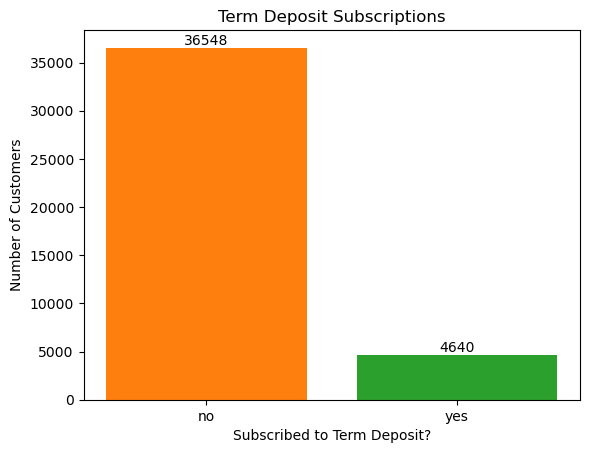

In [6]:
# Count the number of customers in each class 
counts = data['y'].value_counts()

# Create a bar chart with the counts
class_bar = plt.bar(counts.index, counts.values, color=['C1', 'C2'])

# Add labels and title
plt.xlabel('Subscribed to Term Deposit?')
plt.ylabel('Number of Customers')
plt.title('Term Deposit Subscriptions')
plt.bar_label(class_bar)

# Show the plot
plt.show()



Below we see the data is imbalanced and will have to balance the data set

In [7]:
# Select 'unknown' values in the dataset. Doing so converts 'unknown' values to NaN.
df = data[~(data == "unknown")]
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
# View number of 'unknown' values that were convert to NaN in each column. 
df.isna().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

### Balancing the Dataset 

In [9]:
# Select all records classified as 'yes'
yes_df = df[df['y'] == 'yes']

# Select all records classified as 'no'
no_df = df[df['y'] == 'no']

# Randomly select an equal number of records classified as 'no'
num_yes = len(yes_df)
no_df_sampled = no_df.sample(n=num_yes, random_state=42)  # using a fixed random state for reproducibility

# Combine the selected 'yes' and 'no' records into a single DataFrame
final_df = pd.concat([yes_df, no_df_sampled])

# Shuffle the order of the rows in the DataFrame
final_df = final_df.sample(frac=1, random_state=42)  # using a fixed random state for reproducibility

# Print the first few rows of the final DataFrame to verify the results
final_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
27154,50,technician,married,basic.9y,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,yes
41174,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,...,1,1,6,success,-1.1,94.767,-50.8,1.031,4963.6,yes
39213,49,blue-collar,married,basic.9y,NaN,no,no,cellular,mar,mon,...,1,3,1,success,-1.8,93.369,-34.8,0.652,5008.7,yes
23896,49,services,married,NaN,no,no,no,telephone,aug,fri,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
21715,31,technician,single,university.degree,no,yes,no,cellular,aug,tue,...,9,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,yes


In [10]:
final_df['y'].value_counts()

yes    4640
no     4640
Name: y, dtype: int64

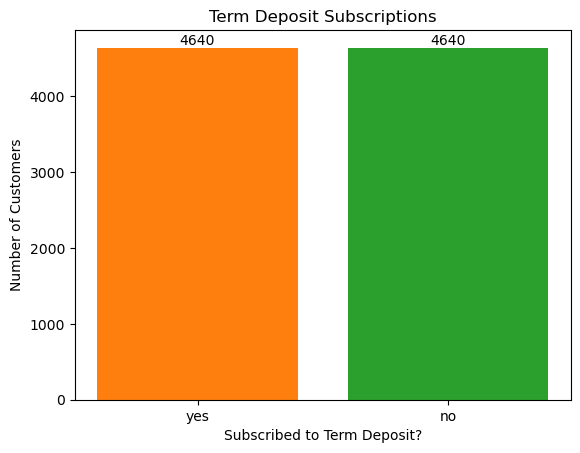

In [11]:
# Count the number of customers in each class 
counts = final_df['y'].value_counts()

# Create a bar chart with the counts
class_bar = plt.bar(counts.index, counts.values, color=['C1', 'C2'])

# Add labels and title
plt.xlabel('Subscribed to Term Deposit?')
plt.ylabel('Number of Customers')
plt.title('Term Deposit Subscriptions')
plt.bar_label(class_bar)

# Show the plot
plt.show()

In [12]:
data_nb = final_df.copy()

In [13]:
#split the data into training (60%) and testing (40%)
predictors = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']

outcome = data_nb['y']

X = pd.get_dummies(data_nb[predictors]) #create dummy variables for predictors
y = data_nb['y']
classes = ['yes','no']

#split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# Use the MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to all features in training data
scaler.fit(X_train)

# Apply the scaler to the features in the training and validation data
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [14]:
# Define the output labels
output_labels = {0: 'No', 1: 'Yes'}

# Run Multinomial Naive Bayes
data_nb = MultinomialNB()
data_nb.fit(X_train_scaled, y_train)  # Pass the scaled training data

# Predict probabilities of each record to its class
predProb_train = data_nb.predict_proba(X_train_scaled)  # Pass the scaled training data
predProb_valid = data_nb.predict_proba(X_valid_scaled)  # Pass the scaled validation data

# Convert the predicted probabilities to pandas data frame as a check and for data visualization
train_df = pd.DataFrame(predProb_train, columns=classes)
valid_df = pd.DataFrame(predProb_valid, columns=classes)

# Predict class membership (shows the class instead of probability by selecting the class with the highest probability)
y_valid_pred = data_nb.predict(X_valid_scaled)  # Pass the scaled validation data
y_train_pred = data_nb.predict(X_train_scaled)  # Pass the scaled training data

# Map the predicted class values to the output labels
y_valid_pred_labels = pd.Series(y_valid_pred).map(output_labels)
y_train_pred_labels = pd.Series(y_train_pred).map(output_labels)

# Print the pandas data frames with the output labels
print("Train Data Prediction Probabilities:\n", train_df.head())
print("\n\nValidation Data Prediction Probabilities:\n", valid_df.head())

Train Data Prediction Probabilities:
         yes        no
0  0.560169  0.439831
1  0.912145  0.087855
2  0.110111  0.889889
3  0.667250  0.332750
4  0.041312  0.958688


Validation Data Prediction Probabilities:
         yes        no
0  0.005951  0.994049
1  0.602340  0.397660
2  0.975703  0.024297
3  0.769845  0.230155
4  0.324094  0.675906


In [15]:
#y_valid_pred_labels
y_train.head()

32776     no
9406      no
29050     no
13045     no
27690    yes
Name: y, dtype: object

The above is the construction of the multinomial Naive Bayes algorithm on training data and validation data, which is split 60% for training and 40% for validation. It runs on scaled training data to obtain the probabilities of each record in both classes. Then the probabiliites are converted into pandas data frames to visualize and check the data, then using the predict() method, the class of each record is predicted. The output reflect the first five rows for both training and validation data, which again reflects the probability of each record belonging to their respective class.

In [16]:
classificationSummary(y_valid, y_valid_pred)

Confusion Matrix (Accuracy 0.7266)

       Prediction
Actual    0    1
     0 1474  375
     1  640 1223


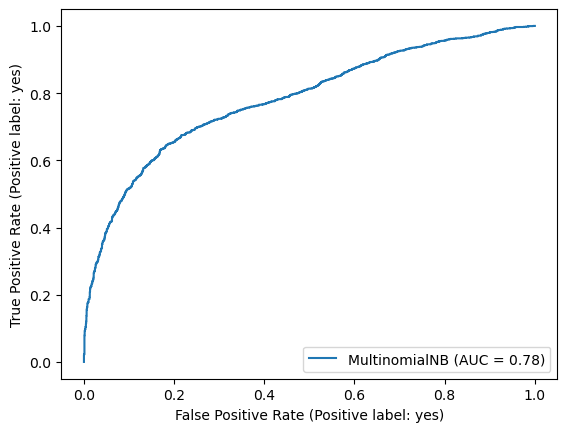

In [17]:
# Create ROC curve object and display it
# Plot ROC curve for Naive Bayes Model
plot_roc_curve(data_nb, X_valid_scaled, y_valid)
plt.show()

In [18]:
#Calculate false positive and true positive rate for final comparision between each model using ROC Curve

# Predict probabilities on the valid set
y_prob_nb = data_nb.predict_proba(X_valid_scaled)[:,1]

# Compute the false positive rate and true positive rate for
#Naive Bayes
fpr_nb, tpr_nb, thresholds = roc_curve(y_valid, y_prob_nb, pos_label='yes')
roc_auc_nb = auc(fpr_nb, tpr_nb)
roc_auc_nb

0.782992765380425

In [19]:
# Extract accuracy score for plotting later on
acc_nb = accuracy_score(y_valid, y_valid_pred).round(2)
acc_nb

0.73